# Preliminaries

Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [1]:
!pip freeze > kaggle_image_requirements.txt

# Download IMDB Movie Review Dataset
Download IMDB dataset

In [2]:
import random
import pandas as pd

## Read-in the reviews and print some basic descriptions of them

!wget -q "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar xzf aclImdb_v1.tar.gz

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)


# Define Tokenization, Stop-word and Punctuation Removal Functions
Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters


In [3]:
Nsamp = 1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

**Tokenization**

In [4]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        tokens = row.split(" ")[:maxtokens]
    return tokens

**Use regular expressions to remove unnecessary characters** 

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [5]:
import re

def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower() # make all characters lower case
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

**Stop-word removal**

Stop-words are also removed. Stop-words are words that are very common in text but offer no useful information that can be used to classify the text. Words such as is, and, the, are are examples of stop-words. The NLTK library contains a list of 127 English stop-words and can be used to filter our tokenized strings.

In [6]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    

# print(stopwords) # see default stopwords
# it may be beneficial to drop negation words from the removal list, as they can change the positive/negative meaning
# of a sentence
# stopwords.remove("no")
# stopwords.remove("nor")
# stopwords.remove("not")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

# Bag-of-words model 

For the computer to make inferences of the e-mails, it has to be able to interpret the text by making a numerical representation of it. One way to do this is by using something called a "bag-of-words" model. This model simply counts the frequency of word tokens for each email and thereby represents it as a vector of these counts.

** Assemble matrices function**

The `assemble_bag()` function assembles a new dataframe containing all the unique words found in the text documents. It counts the word frequency and then returns the new dataframe.

In [8]:
def assemble_bag(data):
    used_tokens = []
    all_tokens = []

    for item in data:
        for token in item:
            if token in all_tokens:
                if token not in used_tokens:
                    used_tokens.append(token)
            else:
                all_tokens.append(token)
    
    df = pd.DataFrame(0, index = np.arange(len(data)), columns = used_tokens)
    
    for i, item in enumerate(data):
        for token in item:
            if token in used_tokens:
                df.iloc[i][token] += 1    
    return df

# Putting It All Together To Assemble Dataset

Now, putting all the preprocessing steps together we assemble our dataset...

In [9]:
import os
import numpy as np

# shuffle raw data first
def unison_shuffle_data(data, header):
    p = np.random.permutation(len(header))
    data = data[p]
    header = np.asarray(header)[p]
    return data, header

# load data in appropriate form
def load_data(path):
    data, sentiments = [], []
    for folder, sentiment in (('neg', 0), ('pos', 1)):
        folder = os.path.join(path, folder)
        for name in os.listdir(folder):
            with open(os.path.join(folder, name), 'r') as reader:
                  text = reader.read()
            text = tokenize(text)
            text = stop_word_removal(text)
            text = reg_expressions(text)
            data.append(text)
            sentiments.append(sentiment)
    data_np = np.array(data)
    data, sentiments = unison_shuffle_data(data_np, sentiments)
    
    return data, sentiments

train_path = os.path.join('aclImdb', 'train')
test_path = os.path.join('aclImdb', 'test')
raw_data, raw_header = load_data(train_path)

print(raw_data.shape)
print(len(raw_header))

(25000,)
25000


In [10]:
# Subsample required number of samples
random_indices = np.random.choice(range(len(raw_header)),size=(Nsamp*2,),replace=False)
data_train = raw_data[random_indices]
header = raw_header[random_indices]

print("DEBUG::data_train::")
print(data_train)

DEBUG::data_train::
[list(['i', 'dragged', 'movie', 'four', 'years', 'ago', 'french', 'actress', 'friend', 'minebr', 'br', 'for', 'first', 'half', 'hour', 'i', 'sitting', 'uncomfortable', 'seat', 'new', 'beverly', 'theater', 'hollywood', 'hating', 'film', 'hating', 'even', 'hating', 'french', 'actress', 'and', 'thenbr', 'br', 'i', 'know', 'happened', 'i', 'pulled', 'film', 'way', 'i', 'years', 'and', 'despite', 'fact', 'one', 'projectors', 'broke', 'changeover', 'hand', 'i', 'theater', 'close', 'four', 'hours', 'worth', 'it', 'br', 'br', 'i', 'believe', 'great', 'movies', 'pull', 'inside', 'world', 'make', 'part', 'drop', 'talk', 'friends', 'coffee', 'drink', 'this', 'film', 'that', 'it', 'one', 'best', 'filmgoing', 'experiences', 'i', 'ever', 'hadbr', 'br', '', 'br', 'br', ''])
 list(['i', 'entered', 'first', 'comment', 'film', 'almost', 'five', 'years', 'ago', 'then', 'ideas', 'presented', 'movie', 'still', 'seemed', 'mostly', 'fictional', 'indeed', 'could', 'ever', 'transpire', 'all

Display sentiments and their frequencies in the dataset, to ensure it is roughly balanced between classes

In [11]:
unique_elements, counts_elements = np.unique(header, return_counts=True)
print("Sentiments and their frequencies:")
print(unique_elements)
print(counts_elements)

Sentiments and their frequencies:
[0 1]
[ 998 1002]


**Featurize and Create Labels**

In [12]:
MixedBagOfReviews = assemble_bag(data_train)
# this is the list of words in our bag-of-words model
predictors = [column for column in MixedBagOfReviews.columns]

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 300)

MixedBagOfReviews # you could do print(MixedBagOfReviews), but Jupyter displays this nicer for pandas DataFrames

,i,hating,french,actress,br,film,years,and,theater,four,...,terrorist,favours,katy,elviras,sassy,fuss,postings,koreans,stardust,lotr
0,8,3,2,2,7,3,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,9,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,0,0,0,2,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,2,2,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
1997,6,0,0,0,6,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1998,0,0,0,0,6,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# split into independent 70% training and 30% testing sets
data = MixedBagOfReviews.values

idx = int(0.7*data.shape[0])

# 70% of data for training
train_x = data[:idx,:]
train_y = header[:idx]
# remaining 30% for testing
test_x = data[idx:,:]
test_y = header[idx:] 

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(len(train_y))

train_x/train_y list details, to make sure it is of the right form:
1400
[[8 3 2 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]]
[1 1 1 1 1]
1400


# How about other vectorization strategies?

We present other vectorization strategies below, for readers who are interested in exploring them...

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

# create the transform - uncomment the one you want to focus on
# vectorizer = CountVectorizer() # this is equivalent to the bag of words
vectorizer = TfidfVectorizer() # tf-idf vectorizer
# vectorizer = HashingVectorizer(n_features=3000) # hashing vectorizer

In [15]:
# build vocabulary
vectorizer.fit([' '.join(sublst) for sublst in data_train])
# summarize
print(len(vectorizer.vocabulary_))
#print(vectorizer.idf_)
# encode one document
vector = vectorizer.transform([' '.join(data_train[0])])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

USE = False # set this to 'True' if you want to use the vectorizer featurizers instead of the bag-of-words done before
if(USE):
    data = vectorizer.transform([' '.join(sublst) for sublst in data_train]).toarray()
    # 70% of data for training
    train_x = data[:idx,:]
    # remaining 30% for testing
    test_x = data[idx:,:]

    print("train_x/train_y list details, to make sure it is of the right form:")
    print(train_x.shape[0])
    print(train_x)
    print(train_y[:5])
    print(len(train_y))
    predictors = [column for column in vectorizer.vocabulary_]

24743
(1, 24743)
[[0. 0. 0. ... 0. 0. 0.]]


# Logistic Regression Classifier

In [16]:
from sklearn.linear_model import LogisticRegression

def fit(train_x,train_y):
    model = LogisticRegression()

    try:
        model.fit(train_x, train_y)
    except:
        pass
    return model

model = fit(train_x,train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
predicted_labels = model.predict(test_x)

# print all labels for full trasparency
print("DEBUG::The logistic regression predicted labels are::")
print(predicted_labels)

DEBUG::The logistic regression predicted labels are::
[0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1
 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1
 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0
 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1
 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1
 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1
 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1
 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0
 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0

In [18]:
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(test_y, predicted_labels)

print("The logistic regression accuracy score is::")
print(acc_score)

The logistic regression accuracy score is::
0.8066666666666666


# Support Vector Machine Classifier

In [19]:
import time
from sklearn.svm import SVC # Support Vector Classification model

In [20]:
# Create a support vector classifier
clf = SVC(C=1, gamma="auto", kernel='linear',probability=False)

# Fit the classifier using the training data
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the SVC Classifier took %3d seconds"%(end_time-start_time))

# test and evaluate
predicted_labels = clf.predict(test_x)
print("DEBUG::The SVC Classifier predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("The SVC Classifier testing accuracy score is::")
print(acc_score)

Training the SVC Classifier took  28 seconds
DEBUG::The SVC Classifier predicted labels are::
[0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1
 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1
 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1
 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0
 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1
 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1
 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1
 1 0 1

# Random Forests

In [21]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=1, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (spam, not spam?)
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the Random Forest Classifier took %3d seconds"%(end_time-start_time))

predicted_labels = clf.predict(test_x)
print("DEBUG::The RF predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)

print("DEBUG::The RF testing accuracy score is::")
print(acc_score)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training the Random Forest Classifier took   0 seconds
DEBUG::The RF predicted labels are::
[1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1
 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0
 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0
 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0
 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1
 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1
 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1
 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1
 0 0 1 0

# Gradient Boosting Machines


Model Report
Accuracy : 0.9221
AUC Score (Train): 0.983475
CV Score : Mean - 0.8431518 | Std - 0.005596524 | Min - 0.8371327 | Max - 0.850334
Training the Gradient Boosting Classifier took 396 seconds
DEBUG::The Gradient Boosting predicted labels are::
[1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0
 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1
 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1
 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0
 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1
 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1
 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1
 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1
 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 

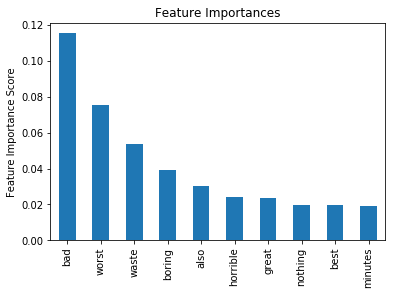

In [22]:
from sklearn.ensemble import GradientBoostingClassifier  # GBM algorithm
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score, GridSearchCV

def modelfit(alg, train_x, train_y, predictors, test_x, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(train_x, train_y)
        
    #Predict training set:
    predictions = alg.predict(train_x)
    predprob = alg.predict_proba(train_x)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, train_x, train_y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_y,predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    import matplotlib.pyplot as plt
    
    if printFeatureImportance:
        fig,ax = plt.subplots()
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp[:10].plot(kind='bar', title='Feature Importances',ax=ax)
        plt.ylabel('Feature Importance Score')
        
        fig.savefig('GBMimportances.eps', format='eps',bbox_inches='tight')
        fig.savefig('GBMimportances.pdf', format='pdf',bbox_inches='tight')
        fig.savefig('GBMimportances.png', format='png',bbox_inches='tight')
        fig.savefig('GBMimportances.svg', format='svg',bbox_inches='tight')
        
    return alg.predict(test_x)
        
gbm = GradientBoostingClassifier(random_state=10)

start_time = time.time()
test_predictions = modelfit(gbm, train_x, train_y, predictors, test_x)
end_time = time.time()
print("Training the Gradient Boosting Classifier took %3d seconds"%(end_time-start_time))

predicted_labels = test_predictions
print("DEBUG::The Gradient Boosting predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)

print("DEBUG::The Gradient Boosting testing accuracy score is::")
print(acc_score)

**Make figures downloadable to local system in interactive mode**

In [23]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='GBMimportances.svg')

In [24]:
# you must remove all downloaded files - having too many of them on completion will make Kaggle reject your notebook 
!rm -rf aclImdb
!rm aclImdb_v1.tar.gz